In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, DataFrame
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler, StringIndexer, Imputer
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.sql.functions import format_number
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import col, sum as _sum, isnan, when

In [57]:
# spark = (SparkSession 
#     .builder 
#     .appName('Project 1') 
#     .getOrCreate())

spark = (SparkSession.builder
 .appName("Project 1")
 .config("spark.executor.resource.gpu.amount", "1")
 .config("spark.task.resource.gpu.amount", "0.1")
 .getOrCreate())


In [58]:
df = spark.read.csv('data.csv', header=True, inferSchema=True)

In [59]:
df.head(5)

[Row(id=842302, diagnosis='M', radius_mean=17.99, texture_mean=10.38, perimeter_mean=122.8, area_mean=1001.0, smoothness_mean=0.1184, compactness_mean=0.2776, concavity_mean=0.3001, concave points_mean=0.1471, symmetry_mean=0.2419, fractal_dimension_mean=0.07871, radius_se=1.095, texture_se=0.9053, perimeter_se=8.589, area_se=153.4, smoothness_se=0.006399, compactness_se=0.04904, concavity_se=0.05373, concave points_se=0.01587, symmetry_se=0.03003, fractal_dimension_se=0.006193, radius_worst=25.38, texture_worst=17.33, perimeter_worst=184.6, area_worst=2019.0, smoothness_worst=0.1622, compactness_worst=0.6656, concavity_worst=0.7119, concave points_worst=0.2654, symmetry_worst=0.4601, fractal_dimension_worst=0.1189, _c32=None),
 Row(id=842517, diagnosis='M', radius_mean=20.57, texture_mean=17.77, perimeter_mean=132.9, area_mean=1326.0, smoothness_mean=0.08474, compactness_mean=0.07864, concavity_mean=0.0869, concave points_mean=0.07017, symmetry_mean=0.1812, fractal_dimension_mean=0.05

In [60]:
df.show(5)

+--------+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+----+
|      id|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|_c32|
+--------+---------+-----------+------

In [61]:
df = df.drop('_c32', 'id')

In [62]:
df.describe().show()

+-------+---------+------------------+-----------------+-----------------+-----------------+--------------------+-------------------+-------------------+--------------------+--------------------+----------------------+------------------+------------------+------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+-----------------+--------------------+-------------------+-------------------+--------------------+-------------------+-----------------------+
|summary|diagnosis|       radius_mean|     texture_mean|   perimeter_mean|        area_mean|     smoothness_mean|   compactness_mean|     concavity_mean| concave points_mean|       symmetry_mean|fractal_dimension_mean|         radius_se|        texture_se|      perimeter_se|          area_se|       smoothness_se|      compactness_se|        concavity_se|   concave points_se|  

In [63]:
df.select([
    _sum(when(isnan(c) | col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df.columns
]).show()


+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+
|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|
+---------+-----------+------------+--------------+---------+-----

In [64]:
df.drop('diagnosis').describe().toPandas().set_index("summary").T.apply(pd.to_numeric, errors='coerce').round(2)

summary,count,mean,stddev,min,max
radius_mean,569,14.13,3.52,6.98,28.11
texture_mean,569,19.29,4.30,9.71,39.28
perimeter_mean,569,91.97,24.30,43.79,188.50
area_mean,569,654.89,351.91,143.50,2501.00
smoothness_mean,569,0.10,0.01,0.05,0.16
compactness_mean,569,0.10,0.05,0.02,0.35
concavity_mean,569,0.09,0.08,0.00,0.43
concave points_mean,569,0.05,0.04,0.00,0.20
symmetry_mean,569,0.18,0.03,0.11,0.30
fractal_dimension_mean,569,0.06,0.01,0.05,0.10


<Axes: xlabel='diagnosis'>

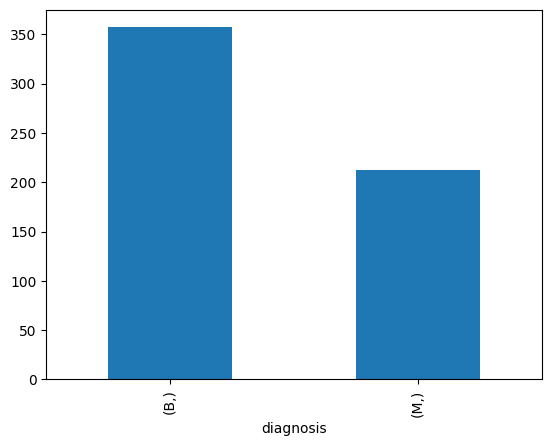

In [65]:
df.select('diagnosis').toPandas().value_counts().plot.bar()

In [66]:
df.printSchema()

root
 |-- diagnosis: string (nullable = true)
 |-- radius_mean: double (nullable = true)
 |-- texture_mean: double (nullable = true)
 |-- perimeter_mean: double (nullable = true)
 |-- area_mean: double (nullable = true)
 |-- smoothness_mean: double (nullable = true)
 |-- compactness_mean: double (nullable = true)
 |-- concavity_mean: double (nullable = true)
 |-- concave points_mean: double (nullable = true)
 |-- symmetry_mean: double (nullable = true)
 |-- fractal_dimension_mean: double (nullable = true)
 |-- radius_se: double (nullable = true)
 |-- texture_se: double (nullable = true)
 |-- perimeter_se: double (nullable = true)
 |-- area_se: double (nullable = true)
 |-- smoothness_se: double (nullable = true)
 |-- compactness_se: double (nullable = true)
 |-- concavity_se: double (nullable = true)
 |-- concave points_se: double (nullable = true)
 |-- symmetry_se: double (nullable = true)
 |-- fractal_dimension_se: double (nullable = true)
 |-- radius_worst: double (nullable = true)


In [67]:
indexer = StringIndexer(
    inputCol='diagnosis',
    outputCol='label',
    handleInvalid='keep'
)

df_indexed = indexer.fit(df).transform(df)
df_indexed.select("diagnosis", "label").show(5)

+---------+-----+
|diagnosis|label|
+---------+-----+
|        M|  1.0|
|        M|  1.0|
|        M|  1.0|
|        M|  1.0|
|        M|  1.0|
+---------+-----+
only showing top 5 rows



In [68]:
df_indexed.filter(df_indexed['diagnosis'] == 'B').select('diagnosis','label').show(5)

+---------+-----+
|diagnosis|label|
+---------+-----+
|        B|  0.0|
|        B|  0.0|
|        B|  0.0|
|        B|  0.0|
|        B|  0.0|
+---------+-----+
only showing top 5 rows



In [69]:
df_indexed = df_indexed.withColumn('label', col('label').cast('integer'))
df_indexed.select('label').show(5)

+-----+
|label|
+-----+
|    1|
|    1|
|    1|
|    1|
|    1|
+-----+
only showing top 5 rows



In [70]:
train_df, test_df = df_indexed.randomSplit([0.75, 0.25], seed=42)

In [71]:
try:
    print(spark._jvm.org.apache.hadoop.util.VersionInfo.getVersion())
except Exception as e:
    print("Brak Hadoop na classpath (Spark without-hadoop?)", e)

3.3.4


In [72]:
feature_cols = df_indexed.columns
feature_cols.remove('diagnosis')
feature_cols.remove('label')

In [73]:
imputer = Imputer(strategy="median", inputCols=feature_cols, outputCols=[f"{c}_imp" for c in feature_cols])

In [74]:
assembled_inputs = [f"{c}_imp" for c in feature_cols]
assembler = VectorAssembler(inputCols=assembled_inputs, outputCol="features")

In [75]:
scaler = StandardScaler(
    inputCol='features',
    outputCol='features_scaled',
    withMean=True,
    withStd=True
)

In [76]:
gbt = GBTClassifier(
    featuresCol="features", 
    labelCol='label', 
    maxDepth=6, 
    maxIter=100, 
    stepSize=0.1
    )

In [77]:
stages = [
    imputer,
    # *indexer,
    # encoder,
    assembler,
    scaler,
    gbt
]

In [78]:
pipe = Pipeline(
    stages = stages
)

In [79]:
# param_grid = (ParamGridBuilder() 
#               .addGrid(gbt.maxDepth, [4, 6, 8]) 
#               .addGrid(gbt.maxIter, [50, 100]) 
#               .addGrid(gbt.stepSize, [0.05, 0.1]) 
#               .build())

param_grid = (ParamGridBuilder() 
              .addGrid(gbt.maxDepth, [4, 6, 8]) 
              .addGrid(gbt.maxIter, [50, 100]) 
              .addGrid(gbt.stepSize, [0.05, 0.1]) 
              .build())
              

In [80]:
evaluator = BinaryClassificationEvaluator(labelCol='label', metricName="areaUnderROC")

In [81]:
cv = CrossValidator(
    estimator=pipe,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=3,
    parallelism=8,      # zwiększ, jeśli masz więcej CPU
    seed=42
)

In [82]:
cv_model = cv.fit(train_df)

In [83]:
# import os
# os.environ["HADOOP_HOME"] = r"C:\hadoop"
# os.environ["hadoop.home.dir"] = r"C:\hadoop"
# os.environ["PATH"] += os.pathsep + r"C:\hadoop\bin"
# os.system("where winutils")

In [84]:
cv_model.bestModel.write().overwrite().save("models/gbt_pipeline_model")

In [85]:
pred_test = cv_model.transform(test_df)
auc = evaluator.evaluate(pred_test)
print(f"AUC (test): {auc:.4f}")

AUC (test): 0.9945


In [86]:
e_bin = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction")

In [87]:
auc_roc = e_bin.setMetricName("areaUnderROC").evaluate(pred_test)
auc_pr  = e_bin.setMetricName("areaUnderPR").evaluate(pred_test)

In [88]:
e_multi = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
acc  = e_multi.setMetricName("accuracy").evaluate(pred_test)
f1   = e_multi.setMetricName("f1").evaluate(pred_test)
prec = e_multi.setMetricName("weightedPrecision").evaluate(pred_test)
rec  = e_multi.setMetricName("weightedRecall").evaluate(pred_test)

In [89]:
print(f"AUC(ROC)={auc_roc:.4f}  AUC(PR)={auc_pr:.4f}  Acc={acc:.4f}  F1={f1:.4f}  Prec={prec:.4f}  Rec={rec:.4f}")

AUC(ROC)=0.9945  AUC(PR)=0.9919  Acc=0.9649  F1=0.9648  Prec=0.9652  Rec=0.9649


In [90]:
cm = (pred_test.groupBy("label")
           .pivot("prediction", [0, 1])
           .count()
           .na.fill(0)
     )
cm.show()

+-----+---+---+
|label|  0|  1|
+-----+---+---+
|    1|  3| 41|
|    0| 69|  1|
+-----+---+---+



In [91]:
pred_test.show(5)

+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+-----+---------------+----------------+------------------+-------------+-------------------+--------------------+------------------+-----------------------+-----------------+--------------------------+-------------+--------------+----------------+-----------+-----------------+------------------+----------------+---------------------+---------------+------------------------+----------------+-----------------+-------------------+--------------+--------------------+---------------------+-------------------+------------------------+

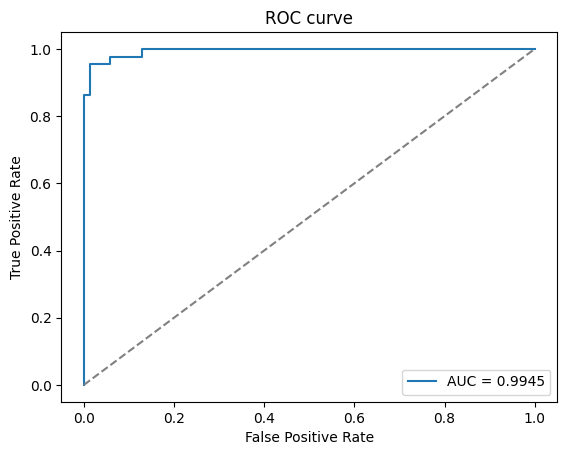

In [92]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

df_pd = pred_test.select('probability','label').toPandas()
y_score = df_pd['probability'].apply(lambda v: v[1]).values
y_true  = df_pd['label'].values
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC curve'); plt.legend(); plt.show()